# Single cosine distance classifier vs Ensemble of 4 classifiers 

### Load data and packages

The directory data  already exists
The directory output  already exists


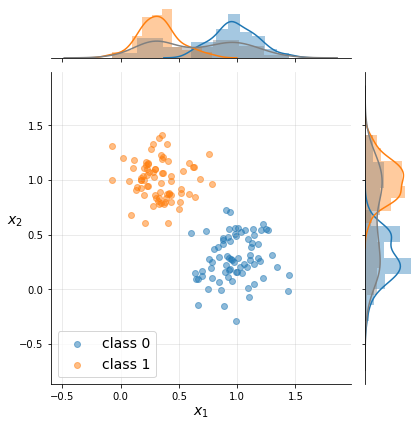

In [3]:
import sys

sys.path.insert(1, '../')

from Utils import *
from modeling import *

create_dir('data')
create_dir('output')

# seed = random.randint(1, 10000)
# np.random.seed(seed)
# print(seed)
seed = 5789
np.random.seed(seed)

test_size = .1

centers = [[1, .3],[.3, 1]]
X, y = load_data( centers = centers, n=150, std=.2, plot = True, save = False)

### Split data in training and test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

Y_vector_train = label_to_array(y_train)
Y_vector_test = label_to_array(y_test)

print("Size Training Set: ", len(X_train))
print("Size Test Set: ", len(X_test))

Size Training Set:  135
Size Test Set:  15


### Quantum cosine classifier for all the observations of the test set

In [8]:
accuracy = []
n_shots = 100

for i in range(10):
    #initialisation
    n = range(len(X_train))
    TP = 0
    predictions = []
    probabilities = []

    for x_test, y_ts in zip(X_test, Y_vector_test):
        ix = np.random.choice(n, 1)[0]
        x_train = X_train[ix]
        x_tr = normalize_custom(x_train)
        y_tr = Y_vector_train[ix]
        x_ts = normalize_custom(x_test)

        qc = cos_classifier(x_tr, x_ts, y_tr)
        r = exec_simulator(qc, n_shots=n_shots)

        if '0' not in r.keys():
            r['0'] = 0
        elif '1' not in r.keys():
            r['1'] = 0

        p0 = (r['0'] / (r['0'] + r['1']))
        p0 = p0
        p1 = 1 - p0

        predictions.append(r)
        probabilities.append(predict_cos(r))
        probs = [p0, p1]


        if predict_cos(r)[0] > predict_cos(r)[1]:
            pred = [1, 0]
            pred = np.asarray(pred)
        else:
            pred = [0, 1]
            pred = np.asarray(pred)

        if np.array_equal(pred, y_ts):
            TP = TP + 1

    accuracy.append(TP / len(X_test))

print('AVG Accuracy multiple cosine classifier:', np.mean(accuracy))
print('STD Accuracy multiple cosine classifier:', np.std(accuracy))

print(qc)

AVG Accuracy multiple cosine classifier: 0.5933333333333333
STD Accuracy multiple cosine classifier: 0.09637888196533971
            ┌─────────────────────────────┐  ░               ░         
    x_b_0: ─┤ Initialize(0.96183,0.27364) ├──░───────X───────░─────────
           ┌┴─────────────────────────────┴┐ ░       │       ░         
 x_test_0: ┤ Initialize(0.99822,-0.059668) ├─░───────X───────░─────────
           └──────┬─────────────────┬──────┘ ░       │       ░         
y_train_0: ───────┤ Initialize(1,0) ├────────░───────┼───────░───■─────
                  └─────────────────┘        ░ ┌───┐ │ ┌───┐ ░ ┌─┴─┐┌─┐
ancilla_0: ──────────────────────────────────░─┤ H ├─■─┤ H ├─░─┤ X ├┤M├
                                             ░ └───┘   └───┘ ░ └───┘└╥┘
      c_0: ══════════════════════════════════════════════════════════╩═
                                                                       


### Choose device

In [9]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
real_device = provider.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2020-05-11 15:19:29,100: Credentials are already in use. The existing account in the session will be replaced.


In [10]:
predictions = []

for x_test, y_ts in zip(X_test, Y_vector_test):

    X_data, Y_data = training_set(X_train, y_train, n=4)
    x_test = normalize_custom(x_test)

    qc = ensemble(X_data, Y_data, x_test, n_swap=1, d=2, balanced=True)
    # qc = transpile(qc, basis_gates = ['u1', 'u2', 'u3', 'cx'], optimization_level=3)
    # r = exec_simulator(qc, n_shots=n_shots)
    
    job = execute(qc, real_device, shots = n_shots)
    results = job.result()
    r = results.get_counts(qc)

    predictions.append(retrieve_proba(r))
    # print(retrieve_proba(r), y_ts)

In [11]:
a, b = evaluation_metrics(predictions, X_test, y_test)

Accuracy= 0.9333333333333333
Brier score= 0.13959333333333332


In [15]:
# qc.draw(output='mpl', scale = .9)
print(qc)

                           ┌───┐                         ┌───┐             ░ »
     q2714_0: ─────────────┤ H ├──────────────■──■──■──■─┤ X ├─■──■──■──■──░─»
                           ├───┤              │  │  │  │ └───┘ │  │  │  │  ░ »
     q2714_1: ─────────────┤ H ├──────────────┼──┼──┼──┼───────┼──┼──┼──┼──░─»
              ┌────────────┴───┴────────────┐ │  │  │  │       │  │  │  │  ░ »
         x_0: ┤ Initialize(0.23341,0.97238) ├─X──┼──┼──┼───────X──┼──┼──┼──░─»
              ├─────────────────────────────┤ │  │  │  │       │  │  │  │  ░ »
         x_1: ┤ Initialize(0.34143,0.93991) ├─X──┼──┼──┼───────X──┼──┼──┼──░─»
              └┬────────────────────────────┤    │  │  │          │  │  │  ░ »
         x_2: ─┤ Initialize(0.91383,0.4061) ├────┼──X──┼──────────┼──X──┼──░─»
              ┌┴────────────────────────────┤    │  │  │          │  │  │  ░ »
         x_3: ┤ Initialize(0.98885,0.14892) ├────┼──X──┼──────────┼──X──┼──░─»
              └─────┬─────────────────┬─────┘    │  

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
real_device = provider.get_backend('ibmq_rome')

In [ ]:
accuracy = []

for i in range(10):
    #initialisation
    n = range(len(X_train))
    TP = 0
    predictions = []
    probabilities = []

    for x_test, y_ts in zip(X_test, Y_vector_test):
        ix = np.random.choice(n, 1)[0]
        x_train = X_train[ix]
        x_tr = normalize_custom(x_train)
        y_tr = Y_vector_train[ix]
        x_ts = normalize_custom(x_test)

        qc = cos_classifier(x_tr, x_ts, y_tr)
        # r = exec_simulator(qc, n_shots=n_shots)
        
        job = execute(qc, real_device, shots = n_shots)
        results = job.result()
        r = results.get_counts(qc)

        if '0' not in r.keys():
            r['0'] = 0
        elif '1' not in r.keys():
            r['1'] = 0

        p0 = (r['0'] / (r['0'] + r['1']))
        p0 = p0
        p1 = 1 - p0

        predictions.append(r)
        probabilities.append(predict_cos(r))
        probs = [p0, p1]


        if predict_cos(r)[0] > predict_cos(r)[1]:
            pred = [1, 0]
            pred = np.asarray(pred)
        else:
            pred = [0, 1]
            pred = np.asarray(pred)

        if np.array_equal(pred, y_ts):
            TP = TP + 1

    accuracy.append(TP / len(X_test))

print('AVG Accuracy multiple cosine classifier:', np.mean(accuracy))
print('STD Accuracy multiple cosine classifier:', np.std(accuracy))

print(qc)

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
real_device = provider.get_backend('ibmq_16_melbourne')

In [ ]:
predictions = []

for x_test, y_ts in zip(X_test, Y_vector_test):

    X_data, Y_data = training_set(X_train, y_train, n=2)
    x_test = normalize_custom(x_test)

    qc = ensemble(X_data, Y_data, x_test, n_swap=1, d=1, balanced=True)
    
    job = execute(qc, real_device, shots = n_shots)
    results = job.result()
    r = results.get_counts(qc)

    predictions.append(retrieve_proba(r))
    print(retrieve_proba(r), y_ts)

In [ ]:
a, b = evaluation_metrics(predictions, X_test, y_test)
print(qc)